In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (3, 3)

from matscipy.dislocation import get_elastic_constants, plot_vitek

from ase.optimize.precon import PreconLBFGS

# interactive visualisation inside the notebook
from nglview import show_ase
def interactive_view(system, scale=0.5):
    view = show_ase(system)
    view._remove_representation()
    view.add_unitcell()
    view.add_spacefill()
    view.update_spacefill(radiusType='covalent',
                          radiusScale=scale)

    view.camera = 'orthographic'
    view.parameters = {"clipDist": 0}

    view.center()
    view._remote_call("setSize", target="Widget", args=["300px", "300px"])
    return view


# Building cylindrical configurations with dislocations

![](dislocation_cylinder.png)

The `matscipy.dislocation` provides a set of tools to create atomistic configurations containing dislocations. In this example we focus on cylindrical configurations. In order to create a dislocation we start with a cylinder of bulk material oriented along the vector of the future dislocation line $\vec l$. By convention assumed in `matscipy.dislocation` Z direction of the cell always corresponds to the dislocation line $\vec l$. Then a displacement field is applied to the cylinder and outer radial shell is fixed in order to stabilise the configuration. So we end up with periodic boundary conditions along the dislocation line (Z) and fixed boundaries along X and Y directions. 

Ase shown on the figure above, screw dislocations are characterised by a displacement with corresponding burgers vector $\vec b$ parallel to the dislocation line $\vec l$, while edge dislocations have the burgers vector $\vec b$ perpendicular to $\vec l$. Here we use an anisotrpoic solution within [Stroh formalism](https://doi.org/10.1080/14786435808565804) to generate displacement field as implemented in [atomman](https://www.ctcms.nist.gov/potentials/atomman/) package. Please note that for this example we use very small systems (small radius). For production calculations one should do a convergence tests with the system size in order to ensure that fixed boundaries do not affect the studied properties.


## Body Centered Cubic 

Here we will use tungsten as an example BCC material. We need lattice parameter $a_0$ and elastic constants $C_{11}$, $C_{12}$ and $C_{44}$ to create dislocation configuration. For the case of _ab initio_ calculation one can provide corresponding values directly. For much faster calculations based on interatomic potentials `matscipy.dislocation` provides a convenient method `get_elastic_constants` to calculate desired properties. We will use and Embedded Atom Potential from [Marinica _et. al._ 2013 paper](http://dx.doi.org/10.1088/0953-8984/25/39/395502) (version EAM4) for the case of tungsten.

In [3]:
# the calculator to provide forces and energies from the potential
from matscipy.calculators.eam import EAM
eam_calc = EAM("../../tests/w_eam4.fs")

# the function accepts any ASE type of calculator
alat, C11, C12, C44 = get_elastic_constants(calculator=eam_calc, symbol="W")

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 23:55:43       -8.896394*       0.7808
FIRE:    1 23:55:43       -8.899920*       0.1160
FIRE:    2 23:55:43       -8.897214*       0.7321
FIRE:    3 23:55:43       -8.898398*       0.5505
FIRE:    4 23:55:43       -8.899676*       0.2427
FIRE:    5 23:55:43       -8.899933*       0.1055
FIRE:    6 23:55:43       -8.899940*       0.0997
FIRE:    7 23:55:43       -8.899952*       0.0883
FIRE:    8 23:55:43       -8.899967*       0.0719
FIRE:    9 23:55:43       -8.899981*       0.0515
FIRE:   10 23:55:43       -8.899991*       0.0281
FIRE:   11 23:55:43       -8.899996*       0.0030
FIRE:   12 23:55:43       -8.899993*       0.0223
FIRE:   13 23:55:43       -8.899993*       0.0220
FIRE:   14 23:55:43       -8.899993*       0.0214
FIRE:   15 23:55:44       -8.899993*       0.0204
FIRE:   16 23:55:44       -8.899994*       0.0192
FIRE:   17 23:55:44       -8.899994*       0.0177
FI

In [4]:
print(f"{alat:.3f} (Angstrom), {C11:.2f}, {C12:.2f}, {C44:.2f} (GPa)")

3.143 (Angstrom), 538.90, 219.93, 178.80 (GPa)


The values are in good agreement with corresponding numbers in the paper: 3.143, 523, 202, 161

### 1/2<111>{110} screw dislocation

The notation 1/2<111>{110} means a dislocation with a burgers vector 1/2<111> and glide plane {110}. For screw dislocation, the dislocation line is parallel to the burgers vector, thus Z direction of the cell will be along <111>. The glide plane {110} fixes the Y direction to be <110> and the X direction is fixed by the geometry to be along <112>. However you do not have to think about it to start since `BCCScrew111Dislocation` object contains all the necessary information. All you need to do is to pass $a_0$ and elastic constants $C_{11}$, $C_{12}$ and $C_{44}$ and the symbol of the desired BCC element to the constructor.

In [5]:
from matscipy.dislocation import BCCScrew111Dislocation

W_screw = BCCScrew111Dislocation(alat, C11, C12, C44, symbol="W")

print("Cell orientation:")
print(W_screw.axes)

print("Burgers vector:")
print(W_screw.burgers)


Cell orientation:
[[ 1  1 -2]
 [-1  1  0]
 [ 1  1  1]]
Burgers vector:
[1.57169589 1.57169589 1.57169589]


We are going to use `BCCScrew111Dislocation.build_cylinder()` method to build the cells. All the necessary parameters are passed automatically and we only need to chose the radius of the cell in (X,Y) plane. The function returns reference bulk cell and a cell containing dislocation. The displacement field is applied iteratively untill a converged value is achieved, the printed output prints the difference between the steps. The radius provided is a parameter is a radius of unconstrained region around the core. The outer shell of fixed atoms is added on top of this. The default value is 10 Angstom which is about two times larger than a cutoff for the used interatomic potential.

In [6]:
W_screw_bulk, W_screw_dislo = W_screw.build_cylinder(radius=20)

interactive_view(W_screw_dislo)

print("\nCell vectors:")
print(W_screw_dislo.cell.array)

print("\nBurgers vector lenth:")
print(np.linalg.norm(W_screw.burgers))

interactive_view(W_screw_dislo)

disloc SCF 0 |d1-d2|_inf = 0.0014003702928255812
disloc SCF 1 |d1-d2|_inf = 6.701013134463585e-06
disloc SCF 2 |d1-d2|_inf = 3.20650794805033e-08

Cell vectors:
[[61.59764738  0.          0.        ]
 [ 0.         62.23598202  0.        ]
 [ 0.          0.          2.72225714]]

Burgers vector lenth:
2.7222571354952314


NGLWidget()


Here we have a cell with $|\vec b| = \frac{\sqrt{3}}{2}a_0$ length along the dislocation line. With a periodic conditions along Z it corresponds to infinitely long straight dislocation line. Note that the periodic boundary conditions along the dislocation line are not applied in the visualisation. It makes it easier to see the displecement, but you might notice the atoms outside the simulation box. 

To increase the size of the cell along the line we can rely on the magic of [ASE](https://wiki.fysik.dtu.dk/ase/) and simply multiply the cell.

In [7]:
interactive_view(W_screw_dislo * [1, 1, 10])

NGLWidget()

Since fo screw dislocations the displacement is parallel to the dislocation line, it is not easy to see the displacement without 3D tools. Thus so-called differential displacement (Vitek) maps are used to visualise the dislocation core. `matscipy.dislocation` offers a tool called {py:meth}`matscipy.dislocation.plot_vitek` to build these maps. The colors of the atoms represent three non equivalen planes of W atoms along <111> direction and the arrows represent the difference in displacement of atoms along Z direction. The visualisation below shows so-called compact and symmetric core, which is the most stable for BCC materials. 

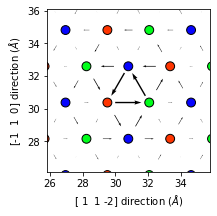

In [10]:
fig, ax = plt.subplots()
plot_vitek(W_screw_dislo, W_screw_bulk, alat=alat, xyscale=5, plot_axes=ax)
ax.set_aspect("equal")
ax.set_xlabel(f"{W_screw.axes[0]} direction ($\AA$)")
ax.set_ylabel(f"{W_screw.axes[1]} direction ($\AA$)");

We can use the ASE minimisation tools to minimise the structure using the chosen interatomic potential:

In [69]:
W_screw_dislo.calc = eam_calc
opt = PreconLBFGS(W_screw_dislo)
opt.run(fmax=0.01)


PreconLBFGS:   0  17:45:43    -1936.097809       2.5284
PreconLBFGS:   1  17:45:46    -1936.291225       0.3596
PreconLBFGS:   2  17:45:47    -1936.346345       0.2286
PreconLBFGS:   3  17:45:48    -1936.361558       0.6206
PreconLBFGS:   4  17:45:48    -1936.374387       0.1534
PreconLBFGS:   5  17:45:49    -1936.377025       0.0604
PreconLBFGS:   6  17:45:50    -1936.378171       0.0846
PreconLBFGS:   7  17:45:52    -1936.378413       0.0449
PreconLBFGS:   8  17:45:52    -1936.378520       0.0124
PreconLBFGS:   9  17:45:53    -1936.378533       0.0059


True

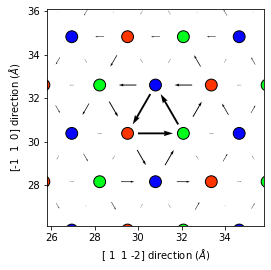

In [70]:
fig, ax = plt.subplots()
plot_vitek(W_screw_dislo, W_screw_bulk, alat=alat, xyscale=5, plot_axes=ax)
ax.set_aspect("equal")
ax.set_xlabel(f"{W_screw.axes[0]} direction ($\AA$)")
ax.set_ylabel(f"{W_screw.axes[1]} direction ($\AA$)");

Differential displacement map of the relaxed structure shows almost the same picture as before with symmetric 'easy' dislocation core. This means that for the selected interatomic potential this structure is indeed the most stable and that the initial guess of the displacement was reasonably good. 

### 1/2<111>{110} edge dislocation

As we said before, for edge dislocations burgers vecort $\vec b$ is perpendicular to the dislocation $\vec l$. So here, we have the same glide plane of (110) which fixes the cell Y direction to <110>. X direction now will be along burgers vector <111> and Z dislocation line direction <112>.

In [71]:
from matscipy.dislocation import BCCEdge111Dislocation

W_edge = BCCEdge111Dislocation(alat, C11, C12, C44, symbol="W")

print("Cell orientation:")
print(W_edge.axes)

print("Burgers vector:")
print(W_edge.burgers)


Cell orientation:
[[ 1  1  1]
 [ 1 -1  0]
 [ 1  1 -2]]
Brurgers vector:
[1.57169589 1.57169589 1.57169589]


In [72]:
W_edge_bulk, W_edge_dislo = W_edge.build_cylinder(radius=15)

print("\nCell vectors:")
print(W_edge_dislo.cell.array)

print("\nBurgers vector lenth:")
print(np.linalg.norm(W_edge.burgers))

interactive_view(W_edge_dislo, scale=0.25)

disloc SCF 0 |d1-d2|_inf = 0.17503856559581366
disloc SCF 1 |d1-d2|_inf = 0.030669955637878832
disloc SCF 2 |d1-d2|_inf = 0.004376523884616179
disloc SCF 3 |d1-d2|_inf = 0.0008807296154242916
disloc SCF 4 |d1-d2|_inf = 0.0001545318258490136
disloc SCF 5 |d1-d2|_inf = 2.611311185346521e-05
disloc SCF 6 |d1-d2|_inf = 5.7489147281541975e-06
disloc SCF 7 |d1-d2|_inf = 7.771344639473377e-07

Cell vectors:
[[54.44514271  0.          0.        ]
 [ 0.         53.34512744  0.        ]
 [ 0.          0.          7.69970592]]

 Burgers vector lenth:
2.7222571354952314


NGLWidget()

It can be seen that the case of edge dislocation the requires more iterations to achieve converged displacement field.

In [73]:
W_edge_dislo.calc = eam_calc
opt = PreconLBFGS(W_edge_dislo)
opt.run(fmax=0.01)

PreconLBFGS:   0  17:45:56    -3017.104358       5.8264
PreconLBFGS:   1  17:46:00    -3017.709448       4.8423
PreconLBFGS:   2  17:46:01    -3018.145844       3.6772
PreconLBFGS:   3  17:46:02    -3018.509917       2.2949
PreconLBFGS:   4  17:46:03    -3018.881065       1.4546
PreconLBFGS:   5  17:46:05    -3019.131877       0.7014
PreconLBFGS:   6  17:46:06    -3019.257094       0.4935
PreconLBFGS:   7  17:46:07    -3019.309591       0.8500
PreconLBFGS:   8  17:46:09    -3019.331649       0.4274
PreconLBFGS:   9  17:46:11    -3019.339919       0.2540
PreconLBFGS:  10  17:46:13    -3019.343713       0.2224
PreconLBFGS:  11  17:46:14    -3019.345547       0.3021
PreconLBFGS:  12  17:46:16    -3019.347613       0.1698
PreconLBFGS:  13  17:46:17    -3019.348607       0.0915
PreconLBFGS:  14  17:46:19    -3019.349042       0.0348
PreconLBFGS:  15  17:46:20    -3019.349154       0.0489
PreconLBFGS:  16  17:46:21    -3019.349259       0.0276
PreconLBFGS:  17  17:46:23    -3019.349286      

True

In [74]:
interactive_view(W_edge_dislo, scale=0.25)

NGLWidget()

It can be seen that relaxed core structure differs significantly from the initial guess.

### 1/2<111>{110} mixed dislocation

For mixed dislocation the cell vector are the same as for the screw dislocation. However the displacement vector is applied along <111> direction that is not parallel to the Z direction: [$1\bar 11$] and [$1\bar 1 \bar1$] with an angle of 70.5 degrees between the vectors. This leads to both edge and screw component in the displacement and thus the name _mixed_ dislocation.

In [104]:
from matscipy.dislocation import BCCMixed111Dislocation

W_mixed = BCCMixed111Dislocation(alat, C11, C12, C44, symbol="W")

print("Cell orientation:")
print(W_mixed.axes)

print("Burgers vector:")
print(W_mixed.burgers)


Cell orientation:
[[ 1 -1 -2]
 [ 1  1  0]
 [ 1 -1  1]]
Burgers vector:
[ 1.57169589 -1.57169589 -1.57169589]


In [105]:
W_mixed_bulk, W_mixed_dislo = W_mixed.build_cylinder(radius=17)

print("\nCell vectors:")
print(W_mixed_dislo.cell.array)

print("\nBurgers vector lenth:")
print(np.linalg.norm(W_mixed.burgers))

interactive_view(W_mixed_dislo, scale=0.5)

disloc SCF 0 |d1-d2|_inf = 0.10539253373490873
disloc SCF 1 |d1-d2|_inf = 0.018105901181897643
disloc SCF 2 |d1-d2|_inf = 0.0028537827503362645
disloc SCF 3 |d1-d2|_inf = 0.0004461832291074441
disloc SCF 4 |d1-d2|_inf = 6.968773949250773e-05
disloc SCF 5 |d1-d2|_inf = 1.0882737324524605e-05
disloc SCF 6 |d1-d2|_inf = 1.6994622201171872e-06
disloc SCF 7 |d1-d2|_inf = 2.6538950442800413e-07

Cell vectors:
[[61.59764738  0.          0.        ]
 [ 0.         62.23598202  0.        ]
 [ 0.          0.          2.72225714]]

Burgers vector lenth:
2.7222571354952314


NGLWidget()

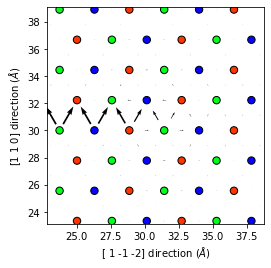

In [111]:
fig, ax = plt.subplots()
plot_vitek(W_mixed_dislo, W_mixed_bulk, alat=alat, xyscale=8, plot_axes=ax)
ax.set_aspect("equal")
ax.set_xlabel(f"{W_mixed.axes[0]} direction ($\AA$)")
ax.set_ylabel(f"{W_mixed.axes[1]} direction ($\AA$)");

It can be seen that the screw displacement component is not local as compared to the case of screw dislocation. This is because in this visualisation edge component of the displacement is not taken into account. It is the full displacement as screw plus edge component that makes a periodic vector leading to perfect structure and thus no displacement far from the dislocation core.

In [112]:
W_mixed_dislo.calc = eam_calc
opt = PreconLBFGS(W_mixed_dislo)
opt.run(fmax=0.01)

PreconLBFGS:   0  18:11:56    -1378.796211       6.1079
PreconLBFGS:   1  18:11:58    -1379.177181       5.5696
PreconLBFGS:   2  18:11:58    -1379.433631       3.8806
PreconLBFGS:   3  18:11:59    -1379.678480       2.8772
PreconLBFGS:   4  18:12:00    -1379.877549       1.7194
PreconLBFGS:   5  18:12:00    -1380.025465       1.0665
PreconLBFGS:   6  18:12:00    -1380.137886       0.4828
PreconLBFGS:   7  18:12:01    -1380.207597       0.7496
PreconLBFGS:   8  18:12:01    -1380.243102       0.6630
PreconLBFGS:   9  18:12:02    -1380.255614       0.5914
PreconLBFGS:  10  18:12:03    -1380.262569       0.6070
PreconLBFGS:  11  18:12:03    -1380.272479       0.2771
PreconLBFGS:  12  18:12:04    -1380.278208       0.2129
PreconLBFGS:  13  18:12:05    -1380.283037       0.2463
PreconLBFGS:  14  18:12:06    -1380.285827       0.1471
PreconLBFGS:  15  18:12:06    -1380.287208       0.1001
PreconLBFGS:  16  18:12:07    -1380.287801       0.0572
PreconLBFGS:  17  18:12:07    -1380.287999      

True

In [91]:
interactive_view(W_mixed_dislo, scale=0.5)

NGLWidget()

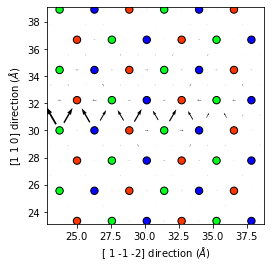

In [113]:
fig, ax = plt.subplots()
plot_vitek(W_mixed_dislo, W_mixed_bulk, alat=alat, xyscale=8, plot_axes=ax)
ax.set_aspect("equal")
ax.set_xlabel(f"{W_mixed.axes[0]} direction ($\AA$)")
ax.set_ylabel(f"{W_mixed.axes[1]} direction ($\AA$)");

Spreading of the dislocation core along the glide plane can be seen in the displacement map after relaxation.

### <100>{110} edge 'junction' dislocation

So called junction dislocations with burdgers vector along <100> can be formed in the reactions between more abundant dislocations with burgers vector <111> such as: 

$$
    \frac{1}{2}[1\bar{1}1] + \frac{1}{2}[11\bar{1}] = [100]
$$

They share the same glide plane ad 1/2<111> dislocations and can play important role in impurity segregation. 

In [114]:
from matscipy.dislocation import BCCEdge100110Dislocation

W_edge = BCCEdge100110Dislocation(alat, C11, C12, C44, symbol="W")

print("Cell orientation:")
print(W_edge.axes)

print("Burgers vector:")
print(W_edge.burgers)


Cell orientation:
[[ 1  0  0]
 [ 0  1  1]
 [ 0 -1  1]]
Burgers vector:
[3.14339178 0.         0.        ]


In [115]:
W_edge_bulk, W_edge_dislo = W_edge.build_cylinder(radius=15)
interactive_view(W_edge_dislo, scale=0.3)

disloc SCF 0 |d1-d2|_inf = 0.2560104778537572
disloc SCF 1 |d1-d2|_inf = 0.060168332357741605
disloc SCF 2 |d1-d2|_inf = 0.008688118653886967
disloc SCF 3 |d1-d2|_inf = 0.002036828550612449
disloc SCF 4 |d1-d2|_inf = 0.00025500431885919217
disloc SCF 5 |d1-d2|_inf = 8.301996157844549e-05
disloc SCF 6 |d1-d2|_inf = 1.657879984715005e-05
disloc SCF 7 |d1-d2|_inf = 1.7271584200617696e-06
disloc SCF 8 |d1-d2|_inf = 6.753730281694459e-07


NGLWidget()

In [116]:
W_edge_dislo.calc = eam_calc
opt = PreconLBFGS(W_edge_dislo)
opt.run(fmax=0.01)

PreconLBFGS:   0  18:20:57    -1730.274578       3.4263
PreconLBFGS:   1  18:20:59    -1730.777063       2.4833
PreconLBFGS:   2  18:20:59    -1731.178752       2.1508
PreconLBFGS:   3  18:21:00    -1731.476037       1.8161
PreconLBFGS:   4  18:21:00    -1731.690456       1.3642
PreconLBFGS:   5  18:21:01    -1731.853182       0.7967
PreconLBFGS:   6  18:21:02    -1731.973529       0.6496
PreconLBFGS:   7  18:21:02    -1732.026735       0.5298
PreconLBFGS:   8  18:21:03    -1732.042318       0.2324
PreconLBFGS:   9  18:21:04    -1732.049330       0.1783
PreconLBFGS:  10  18:21:05    -1732.051240       0.1082
PreconLBFGS:  11  18:21:06    -1732.052185       0.0623
PreconLBFGS:  12  18:21:07    -1732.052429       0.0465
PreconLBFGS:  13  18:21:09    -1732.052507       0.0273
PreconLBFGS:  14  18:21:10    -1732.052541       0.0196
PreconLBFGS:  15  18:21:12    -1732.052557       0.0112
PreconLBFGS:  16  18:21:13    -1732.052567       0.0087


True

In [117]:
interactive_view(W_edge_dislo, scale=0.3)

NGLWidget()

### <100>{001} edge dislocation

This is the same junction dislocation but lying in a different glide plane.

In [118]:
from matscipy.dislocation import BCCEdge100Dislocation

W_edge = BCCEdge100Dislocation(alat, C11, C12, C44, symbol="W")

print("Cell orientation:")
print(W_edge.axes)

print("Burgers vector:")
print(W_edge.burgers)


Cell orientation:
[[ 1  0  0]
 [ 0  0 -1]
 [ 0  1  0]]
Burgers vector:
[3.14339178 0.         0.        ]


In [119]:
W_edge_bulk, W_edge_dislo = W_edge.build_cylinder(radius=15)
interactive_view(W_edge_dislo, scale=0.4)

disloc SCF 0 |d1-d2|_inf = 0.2972369526680858
disloc SCF 1 |d1-d2|_inf = 0.038938521701512574
disloc SCF 2 |d1-d2|_inf = 0.011189887637262474
disloc SCF 3 |d1-d2|_inf = 0.0014928978841749763
disloc SCF 4 |d1-d2|_inf = 0.0004654204442429144
disloc SCF 5 |d1-d2|_inf = 8.16202896045462e-05
disloc SCF 6 |d1-d2|_inf = 1.3592535523576643e-05
disloc SCF 7 |d1-d2|_inf = 4.370933882835715e-06
disloc SCF 8 |d1-d2|_inf = 5.007789461095036e-07


NGLWidget()

In [120]:
W_edge_dislo.calc = eam_calc
opt = PreconLBFGS(W_edge_dislo)
opt.run(fmax=0.01)

PreconLBFGS:   0  18:21:44    -1197.049020       4.0122
PreconLBFGS:   1  18:21:46    -1197.620258       2.9055
PreconLBFGS:   2  18:21:46    -1198.067899       2.6049
PreconLBFGS:   3  18:21:47    -1198.399388       2.4441
PreconLBFGS:   4  18:21:47    -1198.586897       1.1265
PreconLBFGS:   5  18:21:47    -1198.671152       1.3040
PreconLBFGS:   6  18:21:48    -1198.697964       0.7715
PreconLBFGS:   7  18:21:49    -1198.716499       0.2101
PreconLBFGS:   8  18:21:50    -1198.718510       0.1449
PreconLBFGS:   9  18:21:50    -1198.719648       0.1189
PreconLBFGS:  10  18:21:51    -1198.720365       0.0850
PreconLBFGS:  11  18:21:52    -1198.720723       0.0767
PreconLBFGS:  12  18:21:53    -1198.720870       0.0402
PreconLBFGS:  13  18:21:54    -1198.720932       0.0269
PreconLBFGS:  14  18:21:55    -1198.720978       0.0333
PreconLBFGS:  15  18:21:56    -1198.721004       0.0175
PreconLBFGS:  16  18:21:57    -1198.721017       0.0121
PreconLBFGS:  17  18:21:58    -1198.721022      

True

In [121]:
interactive_view(W_edge_dislo, scale=0.4)

NGLWidget()

## Face Centered Cubic

Work in progress.

## Diamond 

Work in progress.